In [29]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd
import numpy as np
import seaborn as sns
from fractions import Fraction as frac

In [30]:
%matplotlib inline

In [31]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("fa21-ds5110-group10-rk") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

In [32]:
spark.sparkContext

<SparkContext master=local[*] appName=fa21-ds5110-group10-rk>

In [33]:
df = spark.read.parquet("../../../data/processed/chess_games_moves_model.parquet")
trainData = spark.read.parquet("../../../data/processed/training.parquet")
testData = spark.read.parquet("../../../data/processed/testing.parquet")

In [34]:
df.cache()
trainData.cache()

DataFrame[event: string, white_result: string, first_two: array<string>, ECO: string, EloDiff: int, Opening: string, game_complexity: int]

In [35]:
opening_vectorizor = StringIndexer(inputCol="ECO", outputCol="opening_ohe")
gametype_vectorizer = StringIndexer(inputCol="event", outputCol="event_vector")
result_vectorizor = StringIndexer(inputCol="white_result", outputCol="white_result_vector")

# NaiveBayes requires non-negative values; we transpose our ELODiff to ABS Value.
df = df.withColumn('EloDiff', F.abs(F.col('EloDiff')))
trainData = trainData.withColumn('EloDiff', F.abs(F.col('EloDiff')))
testData = testData.withColumn('EloDiff', F.abs(F.col('EloDiff')))

In [36]:
move_encoder = OneHotEncoder(inputCols=["opening_ohe"],
                             outputCols=["ECO_Type"])

In [37]:
firsttwo_vectorizer = CountVectorizer(inputCol="first_two", outputCol="first_two_vectorizer")

In [38]:
features_assembler = VectorAssembler(inputCols=['ECO_Type', "EloDiff", "event_vector", "first_two_vectorizer"], outputCol='features')

In [39]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features', labelCol='white_result_vector')

In [40]:
auc_evaluator = BinaryClassificationEvaluator(labelCol='white_result_vector', metricName='areaUnderROC')

In [41]:
SEED = 1337

smoothing = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
grid = ParamGridBuilder()\
        .addGrid(nb.smoothing, smoothing)\
        .build()

numFolds = 10 #2

crossval = CrossValidator(
    estimator=nb,
    estimatorParamMaps=grid,
    evaluator=auc_evaluator,
    numFolds=numFolds,
    parallelism=4,
    seed = SEED)

In [42]:
data_pipeline = Pipeline(stages=[opening_vectorizor,
                                 gametype_vectorizer,
                                 result_vectorizor,
                                 firsttwo_vectorizer,
                                 move_encoder,
                                 features_assembler])

In [43]:
# Create our transforms from our full dataset (considers all cases)
feature_model_df = data_pipeline.fit(df)

# Transform both training and testing dfs
training_df = feature_model_df.transform(trainData)
testing_df = feature_model_df.transform(testData)

In [44]:
%time cvmodel = crossval.setParallelism(4).fit(training_df)

CPU times: user 2.48 s, sys: 719 ms, total: 3.2 s
Wall time: 23min 53s


In [45]:
tuning_params =  [ list(a.values())[0] for a in cvmodel.getEstimatorParamMaps() ]
performance = pd.DataFrame(list(zip(tuning_params, cvmodel.avgMetrics)), columns=['Parameter (smoothing)', 'AUC'])
pd.set_option("precision", 16)

,Parameter (smoothing),AUC
0,0.0,0.5060930644293272
1,0.2,0.5029917755930990
2,0.4,0.5026773679877306
3,0.6,0.5024728333423358
4,0.8,0.5023168739723047
5,1.0,0.5021890045724255


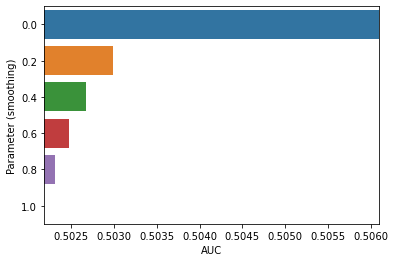

In [46]:
ax = sns.barplot(data=performance, x='AUC', y='Parameter (smoothing)', orient='h')
ax.set(xlim=(min(cvmodel.avgMetrics), max(cvmodel.avgMetrics)))
performance

In [47]:
nb_best = cvmodel.bestModel

In [48]:
auroc = performance.loc[performance['AUC'].idxmax()]['AUC']

In [49]:
ml_pipeline = Pipeline(stages=[nb_best])

In [50]:
model = ml_pipeline.fit(training_df)

In [51]:
result = model.transform(testing_df)

In [52]:
designer_matrix = result.select(['prediction','white_result_vector'])
metrics_rdd = MulticlassMetrics(designer_matrix.rdd.map(tuple))
pd.DataFrame(metrics_rdd.confusionMatrix().toArray())

,0,1
0,322665.0,259097.0
1,277576.0,296784.0


In [53]:
accuracy = metrics_rdd.accuracy
precision = metrics_rdd.precision(1.0)
recall = metrics_rdd.recall(1.0)
f1Score = metrics_rdd.fMeasure(1.0)

label = 1.0
nb_performance = pd.DataFrame([['AUROC', auroc],
                               ['Accuracy',  metrics_rdd.accuracy],
                               ['Precision', metrics_rdd.precision(label)],
                               ['Recall',    metrics_rdd.recall(label)],
                               ['F1 Score',  metrics_rdd.fMeasure(label)]],
                              columns=['Metric', 'Measure'])
nb_performance

,Metric,Measure
0,AUROC,0.5060930644293272
1,Accuracy,0.5357989900719821
2,Precision,0.5338984422925050
3,Recall,0.5167212201406783
4,F1 Score,0.5251694107716850


[(0.5050930644293272, 0.5367989900719821)]

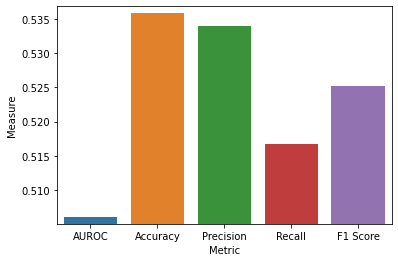

In [54]:
ax2 = sns.barplot(data=nb_performance, x='Metric', y='Measure')
ax2.set(ylim=(min(nb_performance['Measure'])-0.001, max(nb_performance['Measure'])+0.001))

In [70]:
model_result = result.collect()

KeyboardInterrupt: 